# Analyze Missclassifications

In [41]:
from pathlib import Path
import json

import numpy as np
import pandas as pd

## Identify misclassified flows

In [42]:
# Experiment parameters

model = "ensemble_lstm"
dataset = "darpa2000"
scenario = "s1_inside"
window_size = 10
variant = "original"  # or resampled
weights = "no_class_weights"  # or class_weights

processed_dir = f"../data/processed/{dataset}/{scenario}/windowed"
results_dir = f"../experiments/{dataset}/{scenario}/baselines/{model}/results"

metrics_file = f"{results_dir}/{model}_{variant}_{weights}_w{window_size}_metrics.json"

In [43]:
with open(metrics_file) as f:
    metrics = json.load(f)

misclassified_indices = metrics["misclassified_indices"]
real_flow_indices = metrics["real_flow_indices"]


In [44]:
df = pd.read_csv(
    f"../data/interim/{dataset}/{scenario}/flows_labeled/all_flows_labeled.csv"
)

# Sort the DataFrame by start_time to ensure the indices correspond to the original order
df = df.sort_values("start_time").reset_index(drop=True)


In [45]:
mis_df = df.iloc[real_flow_indices].copy()
mis_df

,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,phase
21649,f21870,9.524407e+08,9.524407e+08,0.000000,202.77.162.213,8,172.16.115.5,0,icmp,-,...,T,0,-,1,38,0,0,-,1,1
21659,f21880,9.524407e+08,9.524407e+08,0.000000,202.77.162.213,8,172.16.113.169,0,icmp,-,...,T,0,-,1,38,0,0,-,1,1
24688,f25405,9.524419e+08,9.524420e+08,55.095633,202.77.162.213,55485,172.16.113.105,111,udp,-,...,T,0,D,12,1008,0,0,-,17,2
25739,f26007,9.524421e+08,9.524422e+08,55.104855,202.77.162.213,56263,172.16.112.100,111,udp,-,...,T,0,D,12,1008,0,0,-,17,2
25976,f26287,9.524422e+08,9.524422e+08,55.095159,202.77.162.213,56413,172.16.112.105,111,udp,-,...,T,0,D,12,1008,0,0,-,17,2
25977,f26288,9.524422e+08,9.524422e+08,55.093929,172.16.112.105,3,202.77.162.213,3,icmp,-,...,F,0,-,12,672,0,0,-,1,2
26061,f26394,9.524422e+08,9.524423e+08,55.097203,172.16.112.194,3,202.77.162.213,3,icmp,-,...,F,0,-,12,1344,0,0,-,1,2
29049,f29057,9.524432e+08,9.524432e+08,0.001259,202.77.162.213,60253,172.16.115.20,111,udp,-,...,T,0,Dd,1,84,1,56,-,17,3
29057,f29060,9.524432e+08,9.524432e+08,0.000000,202.77.162.213,60269,172.16.115.20,32773,udp,-,...,T,0,D,1,1440,0,0,-,17,3
29058,f29071,9.524432e+08,9.524432e+08,0.001274,202.77.162.213,60274,172.16.115.20,111,udp,-,...,T,0,Dd,1,84,1,56,-,17,3


## Analyze the misclassified flows

We are specifically interested in flows that were wrongly classified as belonging to a later phase than their true phase. E.g., if a normal flow appearing in the recon phase where classified as ddos, or a recon flow being misclassified as ddos. If this is the case, it showcases a potential benefit of neuro-symbolic AI as the logic can enforce temporal consistency in classification.

In [46]:
mis_df["start_time"] = pd.to_datetime(mis_df["start_time"])
mis_df.sort_values("start_time").head()

,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,phase
21649,f21870,1970-01-01 00:00:00.952440696,9.524407e+08,0.000000,202.77.162.213,8,172.16.115.5,0,icmp,-,...,T,0,-,1,38,0,0,-,1,1
21659,f21880,1970-01-01 00:00:00.952440713,9.524407e+08,0.000000,202.77.162.213,8,172.16.113.169,0,icmp,-,...,T,0,-,1,38,0,0,-,1,1
24688,f25405,1970-01-01 00:00:00.952441929,9.524420e+08,55.095633,202.77.162.213,55485,172.16.113.105,111,udp,-,...,T,0,D,12,1008,0,0,-,17,2
25739,f26007,1970-01-01 00:00:00.952442110,9.524422e+08,55.104855,202.77.162.213,56263,172.16.112.100,111,udp,-,...,T,0,D,12,1008,0,0,-,17,2
25976,f26287,1970-01-01 00:00:00.952442170,9.524422e+08,55.095159,202.77.162.213,56413,172.16.112.105,111,udp,-,...,T,0,D,12,1008,0,0,-,17,2


<Axes: >

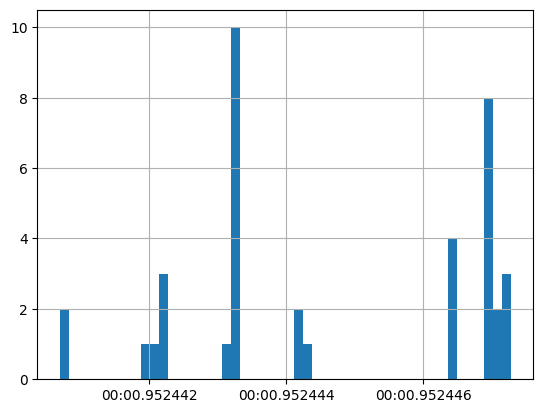

In [47]:
# Plot the distribution of start times for the misclassified flows
mis_df["start_time"].hist(bins=50)


In [48]:
# Errors per phase
mis_df["phase"].value_counts()

phase
5    13
3    11
2     5
0     4
4     3
1     2
Name: count, dtype: int64

In [52]:
benign_flows = mis_df[mis_df['phase'] == 0]
benign_flows.head()

,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,phase
66086,f39831,1970-01-01 00:00:00.952446473,9.524465e+08,0.001326,172.16.113.204,1399,172.16.115.20,53,udp,dns,...,T,0,Dd,1,61,1,119,-,17,0
66119,f39829,1970-01-01 00:00:00.952446473,9.524465e+08,3.491574,172.16.113.204,16404,194.27.251.21,25,tcp,smtp,...,F,0,ShAdDaFf,16,6908,13,853,-,6,0
93042,f39832,1970-01-01 00:00:00.952446475,9.524465e+08,0.001205,172.16.113.204,1400,172.16.115.20,53,udp,dns,...,T,0,Dd,1,73,1,159,-,17,0
114533,f114510,1970-01-01 00:00:00.952446901,9.524469e+08,0.125400,172.16.116.44,22578,207.25.71.200,80,tcp,http,...,F,0,ShADadfF,12,638,29,38426,-,6,0


In [65]:
# Check if any phase 5 flows appeared
phase = 5
before_first_benign = mis_df[mis_df['flow_id'] < benign_flows.iloc[0]['flow_id']]
phase5_before = before_first_benign[before_first_benign['phase'] == phase]

print(f"Benign misclassification flow_ids: {benign_flows['flow_id'].tolist()}")
print(f"Phase {phase} flows before first benign misclassification: {len(phase5_before)}")
phase5_before.head()

Benign misclassification flow_ids: ['f39831', 'f39829', 'f39832', 'f114510']
Phase 5 flows before first benign misclassification: 13


,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,phase
39483,f39454,1970-01-01 00:00:00.952446424,9.524464e+08,0.000658,172.16.115.20,1020,202.77.162.213,1022,tcp,-,...,F,0,FafA,2,80,2,80,-,6,5
114608,f114583,1970-01-01 00:00:00.952446936,9.524469e+08,0.052641,172.16.115.5,22829,131.84.1.31,80,tcp,http,...,F,0,ShADadfF,7,581,9,6530,-,6,5
114612,f114585,1970-01-01 00:00:00.952446937,9.524469e+08,0.078284,172.16.115.5,22956,131.84.1.31,80,tcp,http,...,F,0,ShADdfFa,9,659,12,14998,-,6,5
114614,f114586,1970-01-01 00:00:00.952446937,9.524469e+08,0.042209,172.16.115.5,23020,131.84.1.31,80,tcp,http,...,F,0,ShADdfFa,6,542,6,5082,-,6,5
114616,f114587,1970-01-01 00:00:00.952446937,9.524469e+08,0.053722,172.16.115.5,23083,131.84.1.31,80,tcp,http,...,F,0,ShADadfF,7,583,9,6321,-,6,5
